# Wrangle the stock data

## Preprocessing

In [1]:
%matplotlib inline
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.sectorperformance import SectorPerformances
from alpha_vantage.cryptocurrencies import CryptoCurrencies
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
# Make plots bigger
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
API_KEY = "KRN14ZLFIAEX3YGN"

In [2]:
#download the dataset
ts = TimeSeries(key=API_KEY, output_format='pandas')
#DJI = https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average

#daily - get daily info up to 20a
data, meta_data = ts.get_daily(symbol='DJI', outputsize='full')

In [3]:
# We can describe it
print(data.describe())
print(meta_data)

            1. open       2. high        3. low      4. close     5. volume
count   4722.000000   4722.000000   4722.000000   4722.000000  4.722000e+03
mean   13249.980673  13327.107859  13170.320749  13252.682988  2.136234e+08
std     4309.066962   4312.019326   4306.700543   4310.276441  9.797332e+07
min     6547.009800   6709.609900   6469.950200   6547.049800  8.410000e+06
25%    10368.217275  10429.502450  10292.144775  10368.482900  1.386400e+08
50%    11568.899900  11638.865250  11502.234850  11572.845200  2.090650e+08
75%    16064.364975  16174.142350  15967.260275  16065.444800  2.668525e+08
max    26833.470700  26951.810500  26789.080100  26828.390600  8.239400e+08
{'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'DJI', '3. Last Refreshed': '2018-10-08', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}


In [4]:
print(data.shape)

sample_size = data.shape[0]-1
endpoints = data[1:]
startpoints = data[:sample_size]

print (startpoints.index)
print (endpoints.index)

#save the startpoint index to be used as the date. This way yesterday's bin will hold value
#of change between yesterdays closing and todays closing, so yesterdays tweets get the value impact of today's
#stock market value development
indexes = startpoints.index

#let's reset the indexes
startpoints = startpoints.reset_index()
endpoints = endpoints.reset_index()
print (startpoints.index)
print (endpoints.index)


(4722, 5)
Index(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
       '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13', '2000-01-14',
       ...
       '2018-09-24', '2018-09-25', '2018-09-26', '2018-09-27', '2018-09-28',
       '2018-10-01', '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05'],
      dtype='object', name='date', length=4721)
Index(['2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-10',
       '2000-01-11', '2000-01-12', '2000-01-13', '2000-01-14', '2000-01-18',
       ...
       '2018-09-25', '2018-09-26', '2018-09-27', '2018-09-28', '2018-10-01',
       '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05', '2018-10-08'],
      dtype='object', name='date', length=4721)
RangeIndex(start=0, stop=4721, step=1)
RangeIndex(start=0, stop=4721, step=1)


In [5]:
daily_change = endpoints["4. close"] - startpoints["4. close"]
daily_change.name = "daily change"
df_all = pd.DataFrame(daily_change)

print(daily_change.describe())
print(daily_change.head())

count    4721.000000
mean        3.199926
std       132.366147
min     -1175.210900
25%       -57.849600
50%         6.060600
75%        68.990200
max       936.420000
Name: daily change, dtype: float64
0   -359.5801
1    124.7207
2    130.6094
3    269.2998
4     49.6406
Name: daily change, dtype: float64


### Separate to positive and negative

In [6]:
#upper bonds
import numpy as np

mask = df_all["daily change"] > 0
df_all_pos = df_all.iloc[mask.values]
upper_pos = np.percentile(df_all_pos, 75)
lower_pos = np.percentile(df_all_pos, 25)

print(df_all_pos.describe())
print(upper_pos, lower_pos)

       daily change
count   2500.000000
mean      90.267805
std       87.693889
min        0.149400
25%       28.754825
50%       64.460950
75%      122.430475
max      936.420000
122.43047500000011 28.754825000000437


In [7]:
#lower bonds
df_all_neg = df_all.iloc[(df_all["daily change"] < 0).values]
lower_neg = np.percentile(df_all_neg, 25)
upper_neg = np.percentile(df_all_neg, 75)

print(df_all_neg.describe())
print(lower_neg, upper_neg)

       daily change
count   2218.000000
mean     -94.933572
std      102.227094
min    -1175.210900
25%     -128.132800
50%      -64.104750
75%      -26.677450
max       -0.070400
-128.13280000000077 -26.677450000001045


## Imputating 

In [8]:
df_str = df_all.copy() # to store final classes BIGPOS MEDPOS SMAPOS SMANEG MEDNEG BIGNEG
df_tmp = df_all.copy() # to store the data, overwritten during the process

#returns median of the interval
def update_to_string_classes(df_str, df_tmp, bigger, treshold, string):
    if (bigger):
        mask = (df_tmp["daily change"] > treshold).values
    else:
        mask = (df_tmp["daily change"] < treshold).values
    pos = df_tmp.iloc[mask]
    median = pos.median().values[0]
    pos[:] = string
    df_str.update(pos)
    df_tmp.iloc[mask] = None
    return median

medians = {}
medians["BIGPOS"] = update_to_string_classes(df_str, df_tmp, True, upper_pos, "BIGPOS")
medians["MEDPOS"] = update_to_string_classes(df_str, df_tmp, True, lower_pos, "MEDPOS")
medians["SMAPOS"] = update_to_string_classes(df_str, df_tmp, True, 0, "SMAPOS")
medians["SMANEG"] = update_to_string_classes(df_str, df_tmp, True, upper_neg, "SMANEG")
medians["MEDNEG"] = update_to_string_classes(df_str, df_tmp, True, lower_neg, "MEDNEG")
medians["BIGNEG"] = update_to_string_classes(df_str, df_tmp, False, 0, "BIGNEG")

print("df_tmp unique values", df_tmp["daily change"].unique())
print("df_str unique values", df_str["daily change"].unique())
print("medians", medians)

/home/vili/anaconda3/envs/alphavantage/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/vili/anaconda3/envs/alphavantage/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


df_tmp unique values [nan]
df_str unique values ['BIGNEG' 'BIGPOS' 'MEDPOS' 'MEDNEG' 'SMAPOS' 'SMANEG']
medians {'BIGPOS': 184.91010000000097, 'MEDPOS': 64.46094999999968, 'SMAPOS': 14.310499999999593, 'SMANEG': -11.875, 'MEDNEG': -64.10474999999906, 'BIGNEG': -195.84179999999833}


In [9]:
# change the dates in indexes to pandas Timestamps
indexes = pd.to_datetime(indexes)

#use the saved value for date-data
dates = indexes

#create the missing weekends
print("Before creating the missing days\n", dates[:10], "length ", len(dates))
imp_dates = pd.date_range(dates[0], dates[-1])
print("After creating the missing days\n", imp_dates[:10], "length ", len(imp_dates))

Before creating the missing days
 DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14'],
              dtype='datetime64[ns]', name='date', freq=None) length  4721
After creating the missing days
 DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-08', '2000-01-09', '2000-01-10',
               '2000-01-11', '2000-01-12'],
              dtype='datetime64[ns]', freq='D') length  6851


In [10]:
#impute the missing data with zeros
df_str.index = dates
df_str = df_str.reindex(imp_dates, fill_value=None)

print (df_str["daily change"][:10])

2000-01-03    BIGNEG
2000-01-04    BIGPOS
2000-01-05    BIGPOS
2000-01-06    BIGPOS
2000-01-07    MEDPOS
2000-01-08       NaN
2000-01-09       NaN
2000-01-10    MEDNEG
2000-01-11    MEDPOS
2000-01-12    MEDPOS
Freq: D, Name: daily change, dtype: object


In [11]:
#impute with padding Friday values to the weekend days
df_str = df_str.fillna(method="pad")

print(df_str["daily change"][:10])
print("df_str unique values", df_str["daily change"].unique())

2000-01-03    BIGNEG
2000-01-04    BIGPOS
2000-01-05    BIGPOS
2000-01-06    BIGPOS
2000-01-07    MEDPOS
2000-01-08    MEDPOS
2000-01-09    MEDPOS
2000-01-10    MEDNEG
2000-01-11    MEDPOS
2000-01-12    MEDPOS
Freq: D, Name: daily change, dtype: object
df_str unique values ['BIGNEG' 'BIGPOS' 'MEDPOS' 'MEDNEG' 'SMAPOS' 'SMANEG']


## Visualize

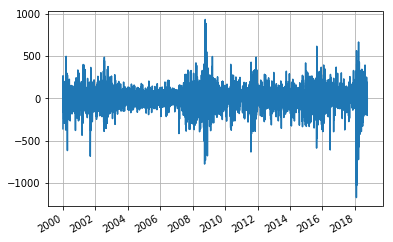

In [12]:
fig, ax = plt.subplots()
ax.plot(dates, daily_change)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()
plt.grid()
plt.show()

In [13]:
a = 365
x = len(df_str.index)

dates_year = df_str.index[x-a:]
data_year = df_str["daily change"][x-a:]


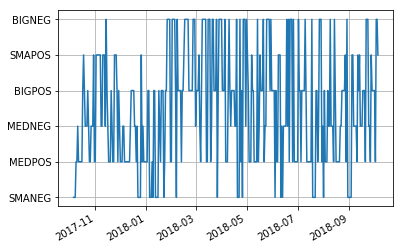

In [14]:
## WATCH OUT FOR Y AXIS LABELS !!!
fig, ax = plt.subplots()
ax.plot(dates_year, data_year)

fig.autofmt_xdate()

plt.grid()
plt.show()

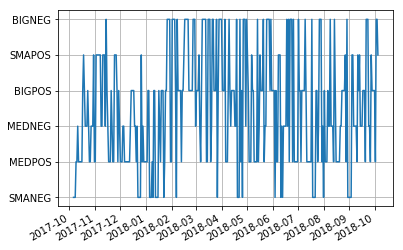

In [15]:
#example of using different locator
import matplotlib.dates as mdates

## WATCH OUT FOR Y AXIS LABELS !!!

fig, ax = plt.subplots()
ax.plot(dates_year, data_year)

#yearLoc = mdates.YearLocator()
#ax.xaxis.set_major_locator(yearLoc)
#ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

monthLoc = mdates.MonthLocator()
ax.xaxis.set_major_locator(monthLoc)
#ax.xaxis.set_minor_locator(monthLoc)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m"))

fig.autofmt_xdate()

plt.grid()
plt.show()

count    4721.000000
mean        3.199926
std       132.366147
min     -1175.210900
25%       -57.849600
50%         6.060600
75%        68.990200
max       936.420000
Name: daily change, dtype: float64


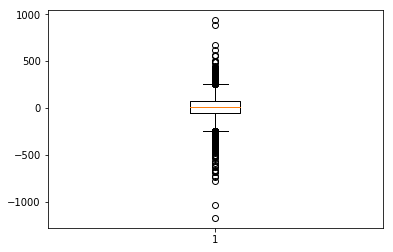

In [16]:
fig, ax = plt.subplots()
ax.boxplot(df_all["daily change"].values)

print(df_all["daily change"].describe())


## Store the data as json

In [17]:
#write data as json
import json

print(df_str.describe())

folder = "../data/"
name = "DJI-20years-daily-change.json"
with open(folder + name, 'w') as file:
    file.write(df_str.to_json())

       daily change
count          6851
unique            6
top          MEDPOS
freq           1753


In [18]:
#read data as json

name = "DJI-20years-daily-change.json"
with open(folder + name, "r") as file:
    read_frame = pd.read_json(file)
print(read_frame.describe())

       daily change
count          6851
unique            6
top          MEDPOS
freq           1753


In [19]:
#write the one year data to json file
df = pd.DataFrame(data_year)
df.index = dates_year
print(df.describe())

folder = "../data/"
latest_date = df.index[-1].strftime('%Y-%m-%d')
name = "DJI-last-year-stock-until-" + latest_date + ".json"

with open(folder + name, "w") as file:
    file.write(df.to_json())

       daily change
count           365
unique            6
top          MEDPOS
freq             89


In [20]:
#read one year data

import os

df = None
os.chdir("../data/")
for filename in os.listdir():
    if os.path.isfile(filename):
        with open(filename, "r") as file:
            if "DJI-last-year-stock-until-" in file.name:
                df = pd.read_json(file)
                break
                
if df is None: print("file not found!")
else: print(df.describe())

       daily change
count           365
unique            6
top          MEDPOS
freq             89
